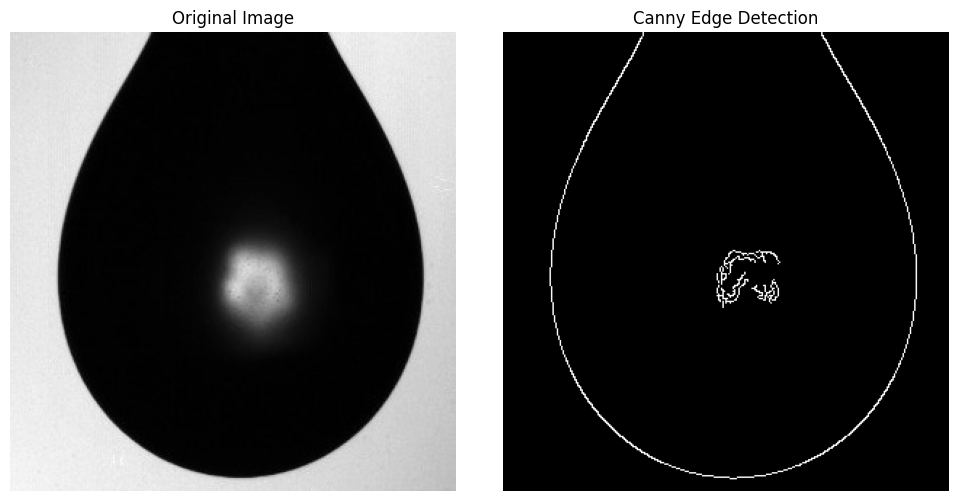

In [55]:
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/pendant_drop (1).jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply Canny edge detection
edges = cv2.Canny(image, threshold1=50, threshold2=150)

# Plot original image and edges side by side
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Edges
plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edge Detection')
plt.axis('off')

plt.tight_layout()
plt.show()


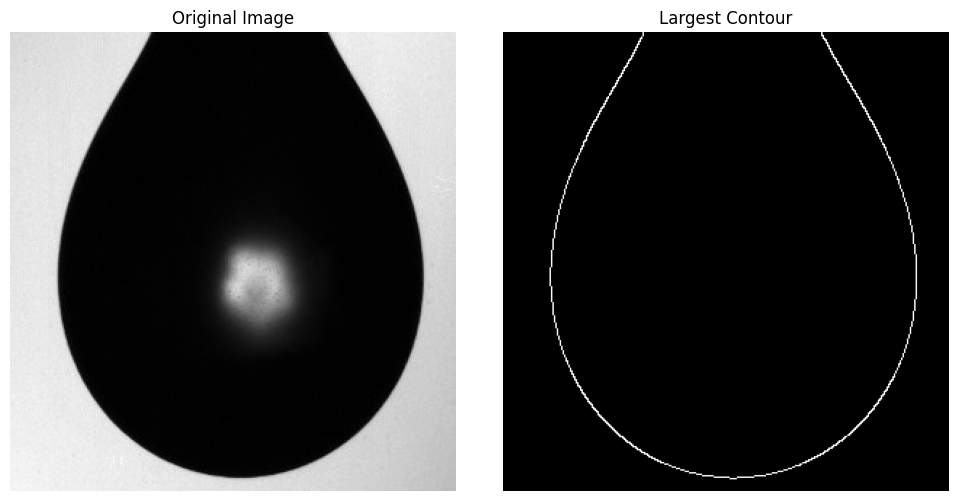

In [56]:
# Apply Canny edge detection again to ensure a clean slate
edges = cv2.Canny(image, threshold1=50, threshold2=150)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a blank image to draw the largest contour
contour_image = np.zeros_like(image)

# Identify the largest contour by area
largest_contour = max(contours, key=cv2.contourArea)

# Draw only the largest contour on the blank image
cv2.drawContours(contour_image, [largest_contour], -1, (255), thickness=1)

# Plot the original image and the largest contour side by side
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Largest contour
plt.subplot(1, 2, 2)
plt.imshow(contour_image, cmap='gray')
plt.title('Largest Contour')
plt.axis('off')

plt.tight_layout()
plt.show()


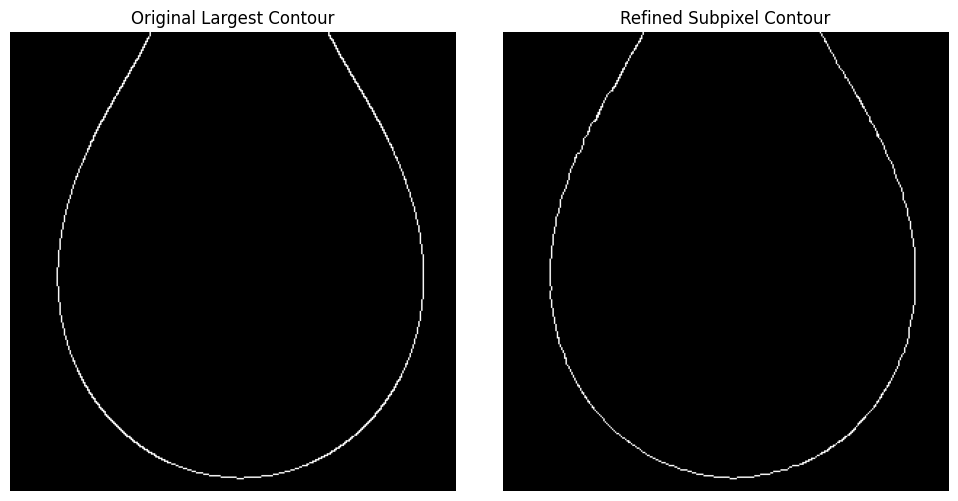

In [57]:
# Apply subpixel smoothing using OpenCV's subpixel contour refinement

# Convert the largest contour into a float array for subpixel processing
largest_contour_float = np.array(largest_contour, dtype=np.float32)

# Perform subpixel contour refinement
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
refined_contour = cv2.cornerSubPix(image, largest_contour_float, (5, 5), (-1, -1), criteria)

# Create a blank image to draw the refined contour
refined_contour_image = np.zeros_like(image)

# Convert refined contour back to integer format for visualization
refined_contour_int = np.array(refined_contour, dtype=np.int32)
cv2.drawContours(refined_contour_image, [refined_contour_int], -1, (255), thickness=1)

# Plot the original contour and the refined contour
plt.figure(figsize=(10, 5))

# Original largest contour
plt.subplot(1, 2, 1)
plt.imshow(contour_image, cmap='gray')
plt.title('Original Largest Contour')
plt.axis('off')

# Refined contour
plt.subplot(1, 2, 2)
plt.imshow(refined_contour_image, cmap='gray')
plt.title('Refined Subpixel Contour')
plt.axis('off')

plt.tight_layout()
plt.show()


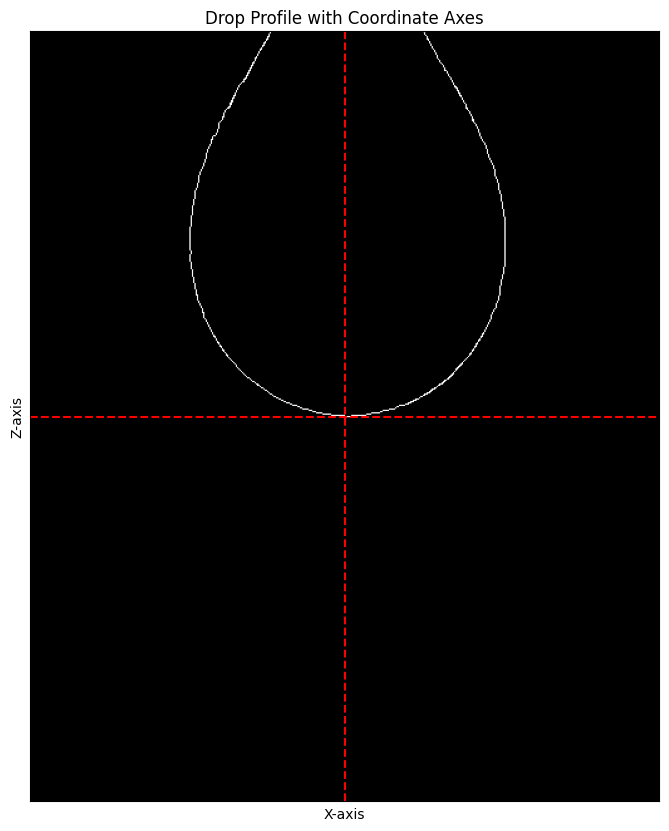

In [63]:
# Redefine corrected_shifted_contour based on earlier computations
bottommost_apex = tuple(refined_contour_int[refined_contour_int[:, :, 1].argmax()][0])  # Bottommost point
corrected_shifted_contour = refined_contour_int - np.array(bottommost_apex)

# Adjust the canvas dimensions and format
canvas_height = int(abs(corrected_shifted_contour[:, :, 1].max() - corrected_shifted_contour[:, :, 1].min()) * 2)
canvas_width = int(abs(corrected_shifted_contour[:, :, 0].max() - corrected_shifted_contour[:, :, 0].min()) * 2)
canvas = np.zeros((canvas_height, canvas_width), dtype=np.uint8)

# Shift the contour to fit within the canvas
canvas_center = (canvas_width // 2, canvas_height // 2)
final_contour = corrected_shifted_contour + np.array(canvas_center)

# Ensure the contour is in integer format for OpenCV
final_contour_int = final_contour.astype(np.int32)

# Draw the contour on the canvas
cv2.drawContours(canvas, [final_contour_int], -1, 255, thickness=1)

# Plot the canvas with coordinate axes
plt.figure(figsize=(10, 10))
plt.imshow(canvas, cmap='gray')

# Draw coordinate axes
plt.axhline(y=canvas_height // 2, color='red', linestyle='--')  # Horizontal axis
plt.axvline(x=canvas_width // 2, color='red', linestyle='--')  # Vertical axis

# Add labels and title
plt.title('Drop Profile with Coordinate Axes')
plt.xlabel('X-axis')
plt.ylabel('Z-axis')
plt.xticks([])
plt.yticks([])
plt.show()



In [64]:
from numpy.polynomial.polynomial import Polynomial

# Extract x and z coordinates from the shifted contour
x_coords = corrected_shifted_contour[:, :, 0].flatten()
z_coords = corrected_shifted_contour[:, :, 1].flatten()

# Filter points close to the origin (bottommost point) for fitting
window = 50  # Consider a window of 50 pixels around the origin
near_origin = (x_coords >= -window) & (x_coords <= window)
x_near_origin = x_coords[near_origin]
z_near_origin = z_coords[near_origin]

# Fit a polynomial (quadratic) to the points near the origin
poly_coeffs = np.polyfit(x_near_origin, z_near_origin, 2)  # Quadratic fit: z = ax^2 + bx + c

# Extract derivatives
a, b, _ = poly_coeffs  # Coefficients of x^2, x, and constant term

# First and second derivatives at the origin
f_prime_0 = b  # First derivative
f_double_prime_0 = 2 * a  # Second derivative

# Calculate radius of curvature R0 at the origin
R0 = (1 + f_prime_0**2) ** (3 / 2) / abs(f_double_prime_0)

R0


110.98902513200515

In [65]:
# Convert R0 from pixels to millimeters using the given resolution
resolution = 1.27 / 116.08  # mm/pixel
R0_mm = R0 * resolution

R0_mm


1.2143010158308627

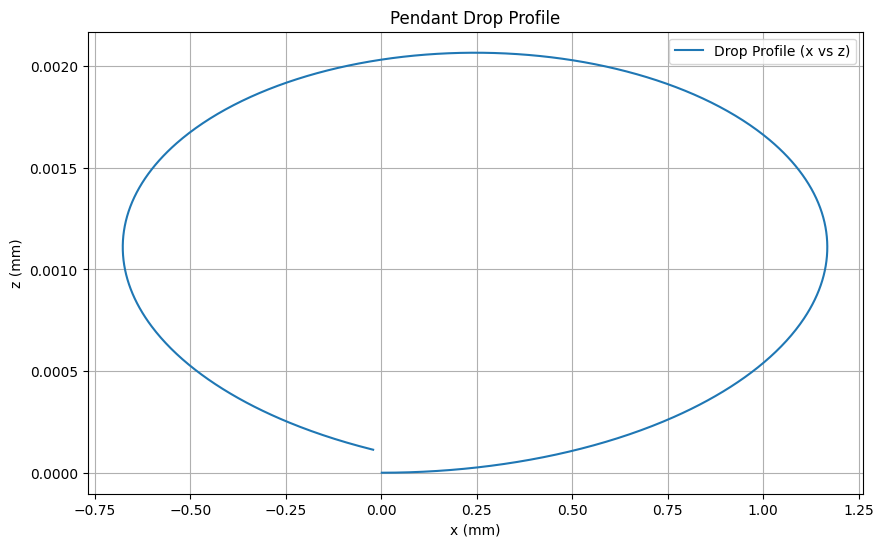

(4.4450352946242946e-09, 9.296117316215453e-06)

In [135]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
density_difference = 998.8  # kg/m^3
g = 9.8  # m/s^2
gamma = 0.07  # N/m (surface tension, assumed value)
R0 = 1.2143010158308627 / 1000  # Convert mm to meters
b = 1 / R0  # inverse of R0
c = density_difference * g / gamma

# Define the system of ODEs
def system(s, state):
    x, z, theta, V, A = state
    dx_ds = np.cos(theta)
    dz_ds = np.sin(theta)
    dtheta_ds = b + c * z - x
    dV_ds = np.pi * x**2 * np.sin(theta)
    dA_ds = 2 * np.pi * x
    return np.array([dx_ds, dz_ds, dtheta_ds, dV_ds, dA_ds])

# Initial conditions
x0 = 1e-6  # Small non-zero value to avoid potential issues
z0, theta0, V0, A0 = 0, 0, 0, 0
initial_state = np.array([x0, z0, theta0, V0, A0])


# RK-4 method for solving the ODEs
def rk4_step(f, s, state, h):
    k1 = f(s, state)
    k2 = f(s + h / 2, state + h * k1 / 2)
    k3 = f(s + h / 2, state + h * k2 / 2)
    k4 = f(s + h, state + h * k3)
    return state + h * (k1 + 2 * k2 + 2 * k3 + k4) / 6

# Solve the system
s_values = np.linspace(0, 0.006, 1000)  # s range (adjust as needed)
h = s_values[1] - s_values[0]  # Step size
states = np.zeros((len(s_values), len(initial_state)))
states[0] = initial_state

for i in range(1, len(s_values)):
    states[i] = rk4_step(system, s_values[i - 1], states[i - 1], h)

# Extract results
x_values, z_values, theta_values, V_values, A_values = states.T
# Convert numerical solution from meters to millimeters
x_values_mm = x_values * 1000  # Convert from meters to millimeters
z_values_mm = z_values * 1000

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_values_mm, z_values, label="Drop Profile (x vs z)")
plt.title("Pendant Drop Profile")
plt.xlabel("x (mm)")
plt.ylabel("z (mm)")
plt.legend()
plt.grid()
plt.show()

# Return final volume and area of the drop
V_final = V_values[-1]
A_final = A_values[-1]

V_final, A_final


In [136]:
# Assuming 'refined_contour' is obtained from your OpenCV processing
# Convert contour to a 2D array of coordinates
experimental_contour = refined_contour.reshape(-1, 2)

# Extract x and y coordinates (Note: OpenCV uses (col, row) which corresponds to (x, y) in images)
x_exp = experimental_contour[:, 0]
z_exp = experimental_contour[:, 1]
x_exp_mm = x_exp * resolution
z_exp_mm = z_exp * resolution



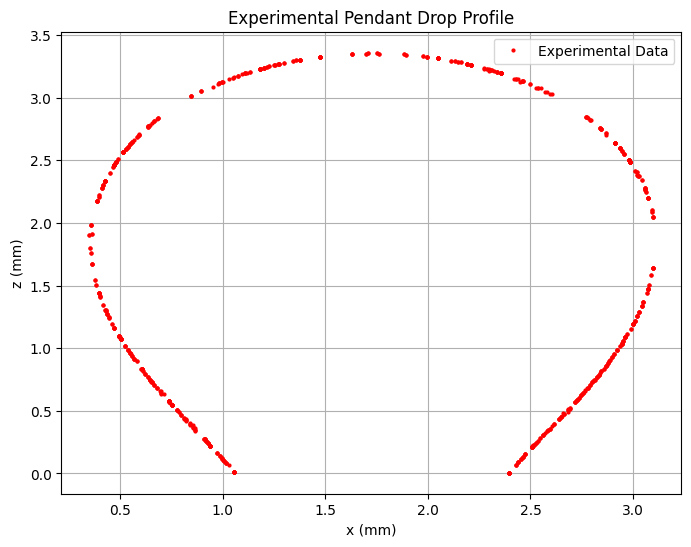

In [84]:
# Plot the experimental data
plt.figure(figsize=(8, 6))
plt.plot(x_exp_mm, z_exp_mm, 'ro', markersize=2, label='Experimental Data')
plt.title('Experimental Pendant Drop Profile')
plt.xlabel('x (mm)')
plt.ylabel('z (mm)')
plt.legend()
plt.grid(True)
plt.show()

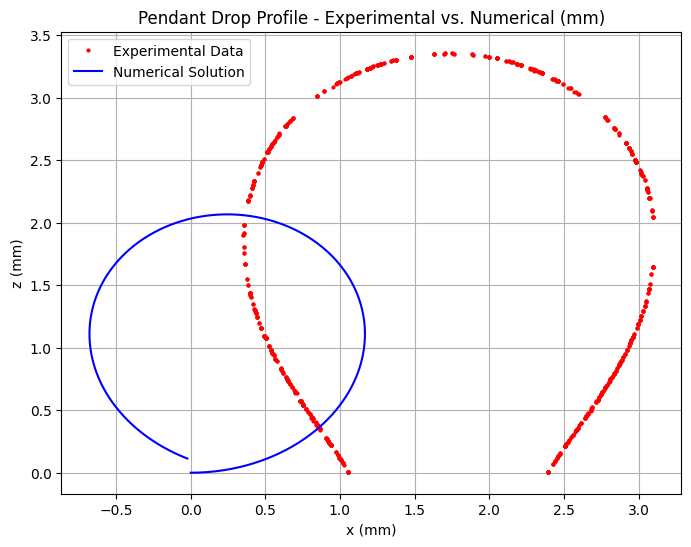

In [139]:
# Plot experimental data and numerical solution
plt.figure(figsize=(8, 6))
plt.plot(x_exp_mm, z_exp_mm, 'ro', markersize=2, label='Experimental Data')
plt.plot(x_values_mm, z_values_mm, 'b-', label='Numerical Solution')
plt.title('Pendant Drop Profile - Experimental vs. Numerical (mm)')
plt.xlabel('x (mm)')
plt.ylabel('z (mm)')
plt.legend()
plt.grid(True)
plt.show()


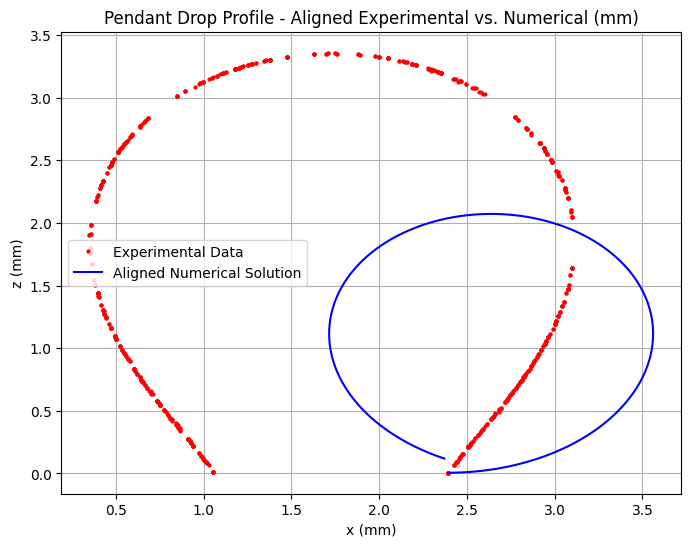

In [140]:
# Determine necessary shifts (if any)
# For example, align the apex (smallest z value)
z_shift = np.min(z_exp_mm) - np.min(z_values_mm)
x_shift = np.mean(x_exp_mm[z_exp_mm == np.min(z_exp_mm)]) - np.mean(x_values_mm[z_values_mm == np.min(z_values_mm)])

# Apply shifts to numerical data
x_values_aligned = x_values_mm + x_shift
z_values_aligned = z_values_mm + z_shift

# Plot aligned data
plt.figure(figsize=(8, 6))
plt.plot(x_exp_mm, z_exp_mm, 'ro', markersize=2, label='Experimental Data')
plt.plot(x_values_aligned, z_values_aligned, 'b-', label='Aligned Numerical Solution')
plt.title('Pendant Drop Profile - Aligned Experimental vs. Numerical (mm)')
plt.xlabel('x (mm)')
plt.ylabel('z (mm)')
plt.legend()
plt.grid(True)
plt.show()


In [141]:
from scipy.optimize import least_squares
from scipy.interpolate import interp1d

def residuals(params, X_exp, Z_exp):
    """
    Compute residuals for least squares fitting.

    params: list
        Model parameters [gamma, R0_meters].
    X_exp: ndarray
        Experimental x-coordinates in mm.
    Z_exp: ndarray
        Experimental z-coordinates in mm.
    """
    gamma, R0_meters = params
    b = 1 / R0_meters
    c = density_difference * g / gamma

    # Define the ODE system for the Laplacian profile
    def system(s, state):
        x, z, theta, V, A = state
        dx_ds = np.cos(theta)
        dz_ds = np.sin(theta)
        dtheta_ds = b + c * z - x
        dV_ds = np.pi * x**2 * np.sin(theta)
        dA_ds = 2 * np.pi * x
        return np.array([dx_ds, dz_ds, dtheta_ds, dV_ds, dA_ds])

    # Solve the ODE system to get the numerical profile
    states = np.zeros((len(s_values), len(initial_state)))
    states[0] = initial_state
    for i in range(1, len(s_values)):
        states[i] = rk4_step(system, s_values[i - 1], states[i - 1], h)

    x_num = states[:, 0] * 1000  # Convert to mm
    z_num = states[:, 1] * 1000  # Convert to mm

    # Interpolate numerical solution to find closest points
    interp_x = interp1d(z_num, x_num, bounds_error=False, fill_value='extrapolate')
    x_closest = interp_x(Z_exp)  # Closest x-coordinates for experimental z-coordinates

    # Compute residuals as differences between experimental and closest numerical points
    residuals = np.sqrt((x_closest - X_exp)**2 + (Z_exp - Z_exp)**2)
    return residuals


In [143]:
# Initial guesses for parameters
gamma_initial = 0.07  # N/m
R0_initial_mm = 1.2143  # mm
R0_initial_meters = R0_initial_mm / 1000  # Convert to meters

params_initial = [gamma_initial, R0_initial_meters]

# Bounds for gamma and R0
gamma_bounds = (0.01, 0.1)  # Bounds for gamma (N/m)
R0_bounds = (0.5e-3, 2e-3)  # Bounds for R0 (meters)

# Perform the least squares fit
result = least_squares(
    fun=residuals,
    x0=params_initial,
    bounds=([gamma_bounds[0], R0_bounds[0]], [gamma_bounds[1], R0_bounds[1]]),
    args=(x_exp_mm, z_exp_mm),
    method='trf',  # Trust Region Reflective algorithm
    verbose=2
)

# Extract optimized parameters
gamma_opt, R0_opt_meters = result.x
R0_opt_mm = R0_opt_meters * 1000  # Convert back to millimeters

print(f"Optimized gamma: {gamma_opt:.5f} N/m")
print(f"Optimized R0: {R0_opt_mm:.5f} mm")


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.8921e+08                                    4.19e+12    
       1              2         1.5598e+08      4.33e+08       1.39e-05       5.51e+11    
       2              3         4.0125e+07      1.16e+08       2.77e-05       7.08e+10    
       3              4         1.6091e+07      2.40e+07       5.52e-05       1.90e+10    
       4              8         1.3575e+07      2.52e+06       1.18e-07       1.47e+10    
       5             10         1.2769e+07      8.06e+05       5.88e-08       1.26e+10    
       6             13         1.2648e+07      1.21e+05       7.15e-09       1.25e+10    
       7             15         1.2588e+07      6.00e+04       3.57e-09       1.24e+10    
       8             17         1.2558e+07      2.99e+04       1.79e-09       1.23e+10    
       9             19         1.2543e+07      1.49e+04       8.93e-10       1.23e+10    